### Examine data from log 0003 - 12 hours, 6 cycles, IBS signals only
1) Examine data
2) Clean data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load project utilities contained in /src
from cs_soh_utils import ensure_time_utc, ensure_dt_index


In [ ]:
# Load in data from 00003 - 12 hours, 6 cycles, IBS signals only

RAW_CSV_DIR = Path("can_data")  # For loading converted raw csv now
CLEANED_CSV_DIR = Path("can_data/cleaned") # For saving *_cleaned.csv file later

path = RAW_CSV_DIR / "12V_IBS_Charge_Discharge_after_IBS_Reset_00003_2025-08-10_08-33-02.csv"
df = pd.read_csv(path)


Have a quick look at the data first before starting to do any cleanning

In [3]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32305 entries, 0 to 32304
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   time_utc_iso                           32305 non-null  object 
 1   time_et_iso                            32305 non-null  object 
 2   excel_utc                              32305 non-null  float64
 3   VCU_IBS_STATUS.IBS_BatteryDefect       32305 non-null  object 
 4   VCU_IBS_STATUS.IBS_Sulfation           32305 non-null  object 
 5   VCU_IBS_STATUS.IBS_EngineStart         32305 non-null  object 
 6   VCU_IBS_STATUS.IBS_PowerOn             32305 non-null  object 
 7   VCU_IBS_STATUS.IBS_LowVoltage          32305 non-null  object 
 8   VCU_IBS_STATUS.IBS_WakeupStatus        32305 non-null  object 
 9   VCU_IBS_STATUS.IBS_SOCUpperTolerance   32305 non-null  int64  
 10  VCU_IBS_STATUS.IBS_SOCLowerTolerance   32305 non-null  int64  
 11  VC

,time_utc_iso,time_et_iso,excel_utc,VCU_IBS_STATUS.IBS_BatteryDefect,VCU_IBS_STATUS.IBS_Sulfation,VCU_IBS_STATUS.IBS_EngineStart,VCU_IBS_STATUS.IBS_PowerOn,VCU_IBS_STATUS.IBS_LowVoltage,VCU_IBS_STATUS.IBS_WakeupStatus,VCU_IBS_STATUS.IBS_SOCUpperTolerance,...,VCU_IBS_UIT.IBS_CurrentAutorange,VCU_IBS_BZE1.IBS_StateOfCharge,VCU_IBS_BZE1.IBS_StateOfHealth,VCU_IBS_BZE1.IBS_EstVoltaDrop,VCU_IBS_BZE1.IBS_OptChargeVolt,VCU_IBS_BZE1.IBS_AvgRi,VCU_IBS_BZE2.IBS_AvailableCapacity,VCU_IBS_BZE2.IBS_DischargeableAh,VCU_IBS_BZE2.IBS_NominalCapacity,VCU_IBS_BZE2.IBS_Recalibrated
count,32305,32305,32305.000000,32305,32305,32305,32305,32305,32305,32305.000000,...,32305,32305.000000,32305.0,32305,32305.000000,3.230500e+04,32305.0,32305.000000,32305.0,32305
unique,32305,32305,NaN,1,1,1,1,1,1,NaN,...,2,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1
top,2025-08-10 12:33:02.000,2025-08-10 08:33:02.000,NaN,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,NaN,...,Current_range_I2,NaN,NaN,SNA,NaN,NaN,NaN,NaN,NaN,Recalibrated
freq,1,1,NaN,32305,32305,32305,32305,32305,32305,NaN,...,30920,NaN,NaN,32305,NaN,NaN,NaN,NaN,NaN,32305
mean,NaN,NaN,45879.709879,NaN,NaN,NaN,NaN,NaN,NaN,6.322798,...,NaN,91.526018,90.0,NaN,13.849085,6.140000e+00,45.0,45.858929,50.0,NaN
std,NaN,NaN,0.107959,NaN,NaN,NaN,NaN,NaN,NaN,6.430819,...,NaN,5.155673,0.0,NaN,0.022418,4.385005e-12,0.0,2.572392,0.0,NaN
min,NaN,NaN,45879.523000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,74.000000,90.0,NaN,13.800000,6.140000e+00,45.0,37.200000,50.0,NaN
25%,NaN,NaN,45879.617000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,89.000000,90.0,NaN,13.850000,6.140000e+00,45.0,44.500000,50.0,NaN
50%,NaN,NaN,45879.710000,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,...,NaN,92.000000,90.0,NaN,13.850000,6.140000e+00,45.0,46.000000,50.0,NaN
75%,NaN,NaN,45879.805000,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,...,NaN,96.000000,90.0,NaN,13.850000,6.140000e+00,45.0,48.100000,50.0,NaN


In [4]:
df.head()


,time_utc_iso,time_et_iso,excel_utc,VCU_IBS_STATUS.IBS_BatteryDefect,VCU_IBS_STATUS.IBS_Sulfation,VCU_IBS_STATUS.IBS_EngineStart,VCU_IBS_STATUS.IBS_PowerOn,VCU_IBS_STATUS.IBS_LowVoltage,VCU_IBS_STATUS.IBS_WakeupStatus,VCU_IBS_STATUS.IBS_SOCUpperTolerance,...,VCU_IBS_UIT.IBS_CurrentAutorange,VCU_IBS_BZE1.IBS_StateOfCharge,VCU_IBS_BZE1.IBS_StateOfHealth,VCU_IBS_BZE1.IBS_EstVoltaDrop,VCU_IBS_BZE1.IBS_OptChargeVolt,VCU_IBS_BZE1.IBS_AvgRi,VCU_IBS_BZE2.IBS_AvailableCapacity,VCU_IBS_BZE2.IBS_DischargeableAh,VCU_IBS_BZE2.IBS_NominalCapacity,VCU_IBS_BZE2.IBS_Recalibrated
0,2025-08-10 12:33:02.000,2025-08-10 08:33:02.000,45879.523,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.4,50,Recalibrated
1,2025-08-10 12:33:03.000,2025-08-10 08:33:03.000,45879.523,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.4,50,Recalibrated
2,2025-08-10 12:33:04.000,2025-08-10 08:33:04.000,45879.523,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated
3,2025-08-10 12:33:05.000,2025-08-10 08:33:05.000,45879.523,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated
4,2025-08-10 12:33:06.000,2025-08-10 08:33:06.000,45879.523,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated


In [5]:
df.tail()

,time_utc_iso,time_et_iso,excel_utc,VCU_IBS_STATUS.IBS_BatteryDefect,VCU_IBS_STATUS.IBS_Sulfation,VCU_IBS_STATUS.IBS_EngineStart,VCU_IBS_STATUS.IBS_PowerOn,VCU_IBS_STATUS.IBS_LowVoltage,VCU_IBS_STATUS.IBS_WakeupStatus,VCU_IBS_STATUS.IBS_SOCUpperTolerance,...,VCU_IBS_UIT.IBS_CurrentAutorange,VCU_IBS_BZE1.IBS_StateOfCharge,VCU_IBS_BZE1.IBS_StateOfHealth,VCU_IBS_BZE1.IBS_EstVoltaDrop,VCU_IBS_BZE1.IBS_OptChargeVolt,VCU_IBS_BZE1.IBS_AvgRi,VCU_IBS_BZE2.IBS_AvailableCapacity,VCU_IBS_BZE2.IBS_DischargeableAh,VCU_IBS_BZE2.IBS_NominalCapacity,VCU_IBS_BZE2.IBS_Recalibrated
32300,2025-08-10 21:31:22.000,2025-08-10 17:31:22.000,45879.9,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,15,...,Current_range_I2,90.0,90.0,SNA,13.8,6.14,45.0,45.2,50,Recalibrated
32301,2025-08-10 21:31:23.000,2025-08-10 17:31:23.000,45879.9,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,15,...,Current_range_I2,90.0,90.0,SNA,13.8,6.14,45.0,45.2,50,Recalibrated
32302,2025-08-10 21:31:24.000,2025-08-10 17:31:24.000,45879.9,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,15,...,Current_range_I2,90.0,90.0,SNA,13.8,6.14,45.0,45.2,50,Recalibrated
32303,2025-08-10 21:31:25.000,2025-08-10 17:31:25.000,45879.9,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,15,...,Current_range_I2,90.0,90.0,SNA,13.8,6.14,45.0,45.2,50,Recalibrated
32304,2025-08-10 21:31:26.000,2025-08-10 17:31:26.000,45879.9,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,15,...,Current_range_I2,90.0,90.0,SNA,13.8,6.14,45.0,45.2,50,Recalibrated


In [6]:
# Convert time to usable format, remove other time columns, and set as index
df = ensure_time_utc(df)
df.head()


,time_utc,VCU_IBS_STATUS.IBS_BatteryDefect,VCU_IBS_STATUS.IBS_Sulfation,VCU_IBS_STATUS.IBS_EngineStart,VCU_IBS_STATUS.IBS_PowerOn,VCU_IBS_STATUS.IBS_LowVoltage,VCU_IBS_STATUS.IBS_WakeupStatus,VCU_IBS_STATUS.IBS_SOCUpperTolerance,VCU_IBS_STATUS.IBS_SOCLowerTolerance,VCU_IBS_STATUS.IBS_CapacityLossTop,...,VCU_IBS_UIT.IBS_CurrentAutorange,VCU_IBS_BZE1.IBS_StateOfCharge,VCU_IBS_BZE1.IBS_StateOfHealth,VCU_IBS_BZE1.IBS_EstVoltaDrop,VCU_IBS_BZE1.IBS_OptChargeVolt,VCU_IBS_BZE1.IBS_AvgRi,VCU_IBS_BZE2.IBS_AvailableCapacity,VCU_IBS_BZE2.IBS_DischargeableAh,VCU_IBS_BZE2.IBS_NominalCapacity,VCU_IBS_BZE2.IBS_Recalibrated
0,2025-08-10 12:33:02+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.4,50,Recalibrated
1,2025-08-10 12:33:03+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.4,50,Recalibrated
2,2025-08-10 12:33:04+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated
3,2025-08-10 12:33:05+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated
4,2025-08-10 12:33:06+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated


In [7]:
# Shorten column names to remove the CAN message and only keep the signal name
new_columns = []
for col in df.columns:
    if '.' in col:
        name = col.split('.', 1)[1]
    else:
        name = col
    new_columns.append(name)

df.columns = new_columns 


In [8]:
df.head()
df.info()
df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32305 entries, 0 to 32304
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   time_utc                32305 non-null  datetime64[ns, UTC]
 1   IBS_BatteryDefect       32305 non-null  object             
 2   IBS_Sulfation           32305 non-null  object             
 3   IBS_EngineStart         32305 non-null  object             
 4   IBS_PowerOn             32305 non-null  object             
 5   IBS_LowVoltage          32305 non-null  object             
 6   IBS_WakeupStatus        32305 non-null  object             
 7   IBS_SOCUpperTolerance   32305 non-null  int64              
 8   IBS_SOCLowerTolerance   32305 non-null  int64              
 9   IBS_CapacityLossTop     32305 non-null  float64            
 10  IBS_CapacityLossBottom  32305 non-null  float64            
 11  IBS_BatteryCurrent      32305 non-null  f

['time_utc',
 'IBS_BatteryDefect',
 'IBS_Sulfation',
 'IBS_EngineStart',
 'IBS_PowerOn',
 'IBS_LowVoltage',
 'IBS_WakeupStatus',
 'IBS_SOCUpperTolerance',
 'IBS_SOCLowerTolerance',
 'IBS_CapacityLossTop',
 'IBS_CapacityLossBottom',
 'IBS_BatteryCurrent',
 'IBS_BatteryVoltage',
 'IBS_BatteryTemperature',
 'IBS_Error',
 'IBS_CurrentAutorange',
 'IBS_StateOfCharge',
 'IBS_StateOfHealth',
 'IBS_EstVoltaDrop',
 'IBS_OptChargeVolt',
 'IBS_AvgRi',
 'IBS_AvailableCapacity',
 'IBS_DischargeableAh',
 'IBS_NominalCapacity',
 'IBS_Recalibrated']

In [9]:
df.head()

,time_utc,IBS_BatteryDefect,IBS_Sulfation,IBS_EngineStart,IBS_PowerOn,IBS_LowVoltage,IBS_WakeupStatus,IBS_SOCUpperTolerance,IBS_SOCLowerTolerance,IBS_CapacityLossTop,...,IBS_CurrentAutorange,IBS_StateOfCharge,IBS_StateOfHealth,IBS_EstVoltaDrop,IBS_OptChargeVolt,IBS_AvgRi,IBS_AvailableCapacity,IBS_DischargeableAh,IBS_NominalCapacity,IBS_Recalibrated
0,2025-08-10 12:33:02+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.4,50,Recalibrated
1,2025-08-10 12:33:03+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.4,50,Recalibrated
2,2025-08-10 12:33:04+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated
3,2025-08-10 12:33:05+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated
4,2025-08-10 12:33:06+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated


Additional clean up steps

In [10]:
# Change column index to time_utc so we can perform time based analysis
df = ensure_dt_index(df, time_col="time_utc")
df.head()


,IBS_BatteryDefect,IBS_Sulfation,IBS_EngineStart,IBS_PowerOn,IBS_LowVoltage,IBS_WakeupStatus,IBS_SOCUpperTolerance,IBS_SOCLowerTolerance,IBS_CapacityLossTop,IBS_CapacityLossBottom,...,IBS_CurrentAutorange,IBS_StateOfCharge,IBS_StateOfHealth,IBS_EstVoltaDrop,IBS_OptChargeVolt,IBS_AvgRi,IBS_AvailableCapacity,IBS_DischargeableAh,IBS_NominalCapacity,IBS_Recalibrated
time_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-10 12:33:02+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,0.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.4,50,Recalibrated
2025-08-10 12:33:03+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,0.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.4,50,Recalibrated
2025-08-10 12:33:04+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,0.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated
2025-08-10 12:33:05+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,0.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated
2025-08-10 12:33:06+00:00,Flag_inactive,Flag_active,Flag_inactive,Flag_inactive,Flag_inactive,No_active_wakeup_demand,0,15,10.0,0.0,...,Current_range_I2,96.5,90.0,SNA,13.85,6.14,45.0,48.3,50,Recalibrated


Convert any non-numeric values to numeric

In [11]:
# Change the IBS status flags from inactive / active to 0/1
df = df.replace({
    'Flag_inactive':0,
    'Flag_active': 1,
    'No_active_wakeup_demand': 0,
    'Active_wakeup_demand':1,
    'SNA':0,
    'Range_not_defined':0,
    'Current_range_I1':1,
    'Current_range_I2':2,
    'Current_range_I3':3, 
    'Not_recalibrated':0,
    'Recalibrated':1,
    'IBS_OK':0,
    'IBS_defect':1

})
df.head()

/var/folders/ng/3vcxzr395fd86ffyyn36q09w0000gn/T/ipykernel_12725/2408628320.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({


,IBS_BatteryDefect,IBS_Sulfation,IBS_EngineStart,IBS_PowerOn,IBS_LowVoltage,IBS_WakeupStatus,IBS_SOCUpperTolerance,IBS_SOCLowerTolerance,IBS_CapacityLossTop,IBS_CapacityLossBottom,...,IBS_CurrentAutorange,IBS_StateOfCharge,IBS_StateOfHealth,IBS_EstVoltaDrop,IBS_OptChargeVolt,IBS_AvgRi,IBS_AvailableCapacity,IBS_DischargeableAh,IBS_NominalCapacity,IBS_Recalibrated
time_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-10 12:33:02+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.4,50,1
2025-08-10 12:33:03+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.4,50,1
2025-08-10 12:33:04+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.3,50,1
2025-08-10 12:33:05+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.3,50,1
2025-08-10 12:33:06+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.3,50,1


In [12]:
# Examine columns with most NaNs 
df.isna().sum().sort_values(ascending=False)

IBS_BatteryDefect         0
IBS_Sulfation             0
IBS_NominalCapacity       0
IBS_DischargeableAh       0
IBS_AvailableCapacity     0
IBS_AvgRi                 0
IBS_OptChargeVolt         0
IBS_EstVoltaDrop          0
IBS_StateOfHealth         0
IBS_StateOfCharge         0
IBS_CurrentAutorange      0
IBS_Error                 0
IBS_BatteryTemperature    0
IBS_BatteryVoltage        0
IBS_BatteryCurrent        0
IBS_CapacityLossBottom    0
IBS_CapacityLossTop       0
IBS_SOCLowerTolerance     0
IBS_SOCUpperTolerance     0
IBS_WakeupStatus          0
IBS_LowVoltage            0
IBS_PowerOn               0
IBS_EngineStart           0
IBS_Recalibrated          0
dtype: int64

In [13]:
df.shape

(32305, 24)

In [14]:
# Drop all rows with missing data
df = df.dropna()

CSV should be completely cleaned now!!

In [15]:
# Check that all data values are numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32305 entries, 2025-08-10 12:33:02+00:00 to 2025-08-10 21:31:26+00:00
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   IBS_BatteryDefect       32305 non-null  int64  
 1   IBS_Sulfation           32305 non-null  int64  
 2   IBS_EngineStart         32305 non-null  int64  
 3   IBS_PowerOn             32305 non-null  int64  
 4   IBS_LowVoltage          32305 non-null  int64  
 5   IBS_WakeupStatus        32305 non-null  int64  
 6   IBS_SOCUpperTolerance   32305 non-null  int64  
 7   IBS_SOCLowerTolerance   32305 non-null  int64  
 8   IBS_CapacityLossTop     32305 non-null  float64
 9   IBS_CapacityLossBottom  32305 non-null  float64
 10  IBS_BatteryCurrent      32305 non-null  float64
 11  IBS_BatteryVoltage      32305 non-null  float64
 12  IBS_BatteryTemperature  32305 non-null  float64
 13  IBS_Error               32305 non-null  int6

In [16]:
# Save cleaned data file for next steps
path = CLEANED_CSV_DIR / "12V_IBS_Charge_Discharge_after_IBS_Reset_00003_cleaned.csv"

df.to_csv(path)

In [17]:
df.head()

,IBS_BatteryDefect,IBS_Sulfation,IBS_EngineStart,IBS_PowerOn,IBS_LowVoltage,IBS_WakeupStatus,IBS_SOCUpperTolerance,IBS_SOCLowerTolerance,IBS_CapacityLossTop,IBS_CapacityLossBottom,...,IBS_CurrentAutorange,IBS_StateOfCharge,IBS_StateOfHealth,IBS_EstVoltaDrop,IBS_OptChargeVolt,IBS_AvgRi,IBS_AvailableCapacity,IBS_DischargeableAh,IBS_NominalCapacity,IBS_Recalibrated
time_utc,,,,,,,,,,,,,,,,,,,,,
2025-08-10 12:33:02+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.4,50,1
2025-08-10 12:33:03+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.4,50,1
2025-08-10 12:33:04+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.3,50,1
2025-08-10 12:33:05+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.3,50,1
2025-08-10 12:33:06+00:00,0,1,0,0,0,0,0,15,10.0,0.0,...,2,96.5,90.0,0,13.85,6.14,45.0,48.3,50,1


In [18]:
df.columns

Index(['IBS_BatteryDefect', 'IBS_Sulfation', 'IBS_EngineStart', 'IBS_PowerOn',
       'IBS_LowVoltage', 'IBS_WakeupStatus', 'IBS_SOCUpperTolerance',
       'IBS_SOCLowerTolerance', 'IBS_CapacityLossTop',
       'IBS_CapacityLossBottom', 'IBS_BatteryCurrent', 'IBS_BatteryVoltage',
       'IBS_BatteryTemperature', 'IBS_Error', 'IBS_CurrentAutorange',
       'IBS_StateOfCharge', 'IBS_StateOfHealth', 'IBS_EstVoltaDrop',
       'IBS_OptChargeVolt', 'IBS_AvgRi', 'IBS_AvailableCapacity',
       'IBS_DischargeableAh', 'IBS_NominalCapacity', 'IBS_Recalibrated'],
      dtype='object')

Let's look at some basic plots of the data to see what we have

<Axes: xlabel='time_utc'>

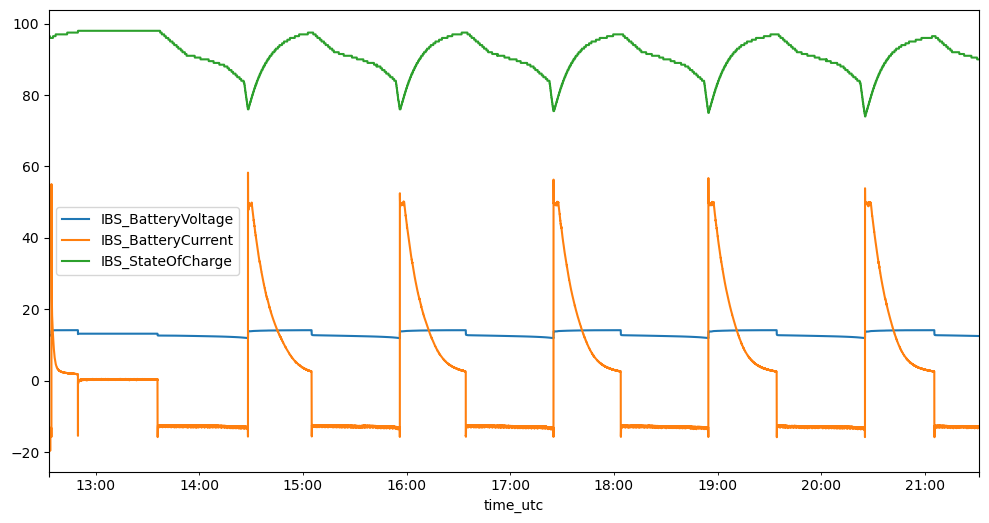

In [19]:
# Pandas plotting for basic signals

df.plot(y=['IBS_BatteryVoltage', 'IBS_BatteryCurrent', 'IBS_StateOfCharge'], figsize=(12,6))


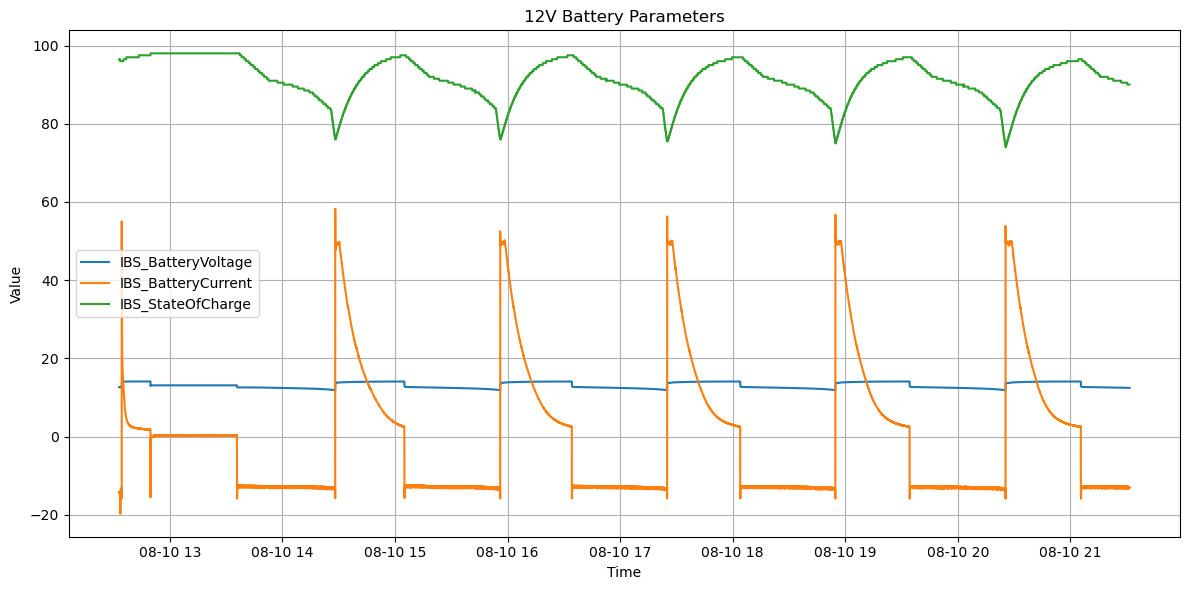

In [20]:
# Matplotlib for basic signals

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index, df['IBS_BatteryVoltage'], label='IBS_BatteryVoltage')
plt.plot(df.index, df['IBS_BatteryCurrent'], label='IBS_BatteryCurrent')
plt.plot(df.index, df['IBS_StateOfCharge'], label='IBS_StateOfCharge')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("12V Battery Parameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


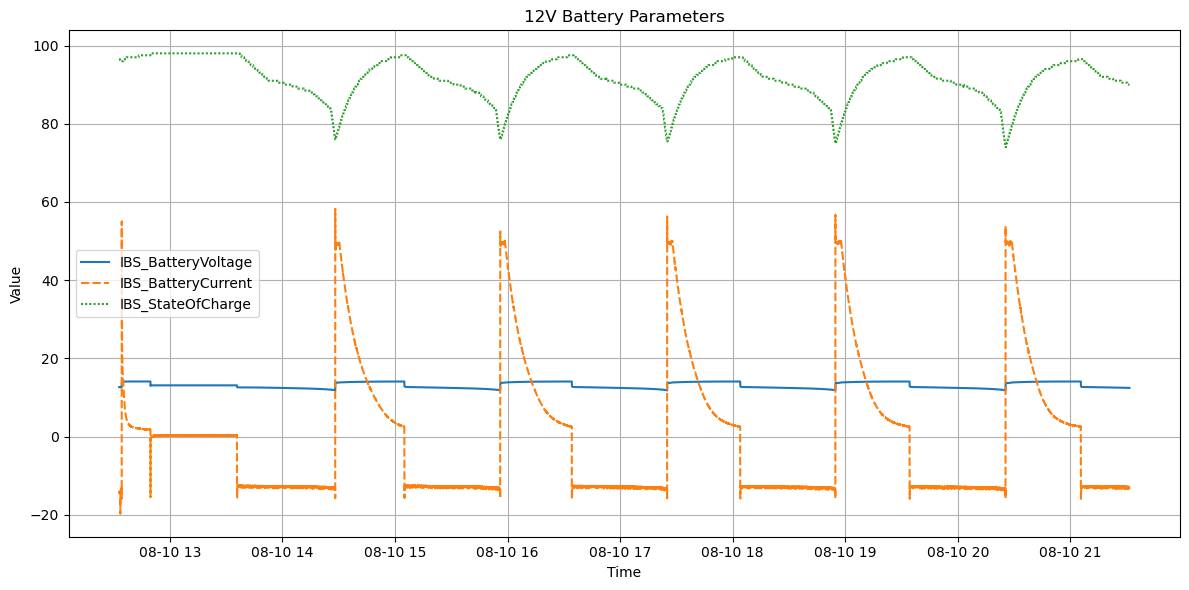

In [21]:
# Seaborn plot of basic signals

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.lineplot(data=df[['IBS_BatteryVoltage', 'IBS_BatteryCurrent', 'IBS_StateOfCharge']])
plt.title("12V Battery Parameters")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()
